### Detectron2 Installation
Setting up detectron2 environment..

In [ ]:
!python -m pip install pyyaml==5.1
!python -m pip install torchvision
# Detectron2 has not released pre-built binaries for the latest pytorch (https://github.com/facebookresearch/detectron2/issues/4053)
# so we install from source instead. This takes a few minutes.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

# Install pre-built detectron2 that matches pytorch version, if released:
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/{CUDA_VERSION}/{TORCH_VERSION}/index.html

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

### Panel Detector

In [78]:
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer

from detectron2.config import get_cfg
from detectron2.projects.point_rend import add_pointrend_config
import detectron2.data.transforms as T
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import GenericMask

from PIL import Image
import numpy as np
import os
import time
from detectron2.utils.visualizer import ColorMode
from IPython.display import display

#!pip install shapely

In [82]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.projects.point_rend import add_pointrend_config

from PIL import Image, ImageFilter
import logging
import time
import numpy as np
import cv2
from scipy.spatial import distance

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class PanelDetector():
    def __init__(self, panel_config, panel_checkpoint, panel_threshold=0.88, model_device='cpu'):
        self.panel_model = None
        self.panel_classes = None
        self.panel_class_metadata = None
        self.panel_config = panel_config
        self.panel_checkpoint = panel_checkpoint
        self.panel_threshold = panel_threshold
        self.model_device = model_device
        self.initialise_panel()

    def initialise_panel(self):

        cfg = get_cfg()
        add_pointrend_config(cfg)
        cfg.merge_from_file(self.panel_config)
        cfg.MODEL.WEIGHTS = self.panel_checkpoint
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = self.panel_threshold
        cfg.MODEL.DEVICE = self.model_device
        self.panel_model = DefaultPredictor(cfg)
        logger.info('Panel Model Loaded')
    
    def predict(self, img):
        '''
        Function that takes in a Numpy Array and country code and returns an Masked Image or None
        '''
        t1 = time.time()
        predictions = self.panel_model(img)
        t2 = time.time()
        logger.info('Panel Detection Model Inference took: {}'.format(str(t2 - t1)))

        instances = predictions["instances"].to("cpu")

        v = Visualizer(
        img_rgb=img,
        instance_mode=ColorMode.SEGMENTATION
        )
        
        out = v.draw_instance_predictions(
        instances
        )
            
        result = {
            'image' : out,
        }

        return result, instances

# if __name__ == "__main__":
#     panel_detector = PanelDetector(
#         panel_config='carro-ds-cv-carro_locus/license_plate_masking/configs/pointrend_rcnn_X_101_32x8d_FPN_3x_coco.yaml',
#         panel_checkpoint='model.pth',
#         )

#     im = '/Users/maixueqiao/Downloads/Project/panel_detection/images/carro_vKT5hkFj7uvDi6WW.jpg'
#     img = np.asarray(Image.open(im))
#     car_results, panel_instances = panel_detector.predict(img)
#     display(Image.fromarray(car_results['image'].get_image()))
    

In [83]:
panel_detector = PanelDetector(
    panel_config='carro-ds-cv-carro_locus/license_plate_masking/configs/pointrend_rcnn_X_101_32x8d_FPN_3x_coco.yaml',
    panel_checkpoint='model.pth',
    )

INFO:fvcore.common.checkpoint:[Checkpointer] Loading from model.pth ...
INFO:detectron2.checkpoint.c2_model_loading:Following weights matched with model:
| Names in Model                                            | Names in Checkpoint                                                                                  | Shapes                                          |
|:----------------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*                         | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| backbone.bottom_up.res2.0.conv2.*                         | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (256,) (256,) (256,) (256,) (256,8,3

### Visualise Panel 

/Users/maixueqiao/opt/miniconda3/envs/my_env/lib/python3.10/site-packages/detectron2/projects/point_rend/point_features.py:142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  point_coords[:, :, 1] = h_step / 2.0 + (point_indices // W).to(torch.float) * h_step
INFO:__main__:Panel Detection Model Inference took: 11.302163124084473


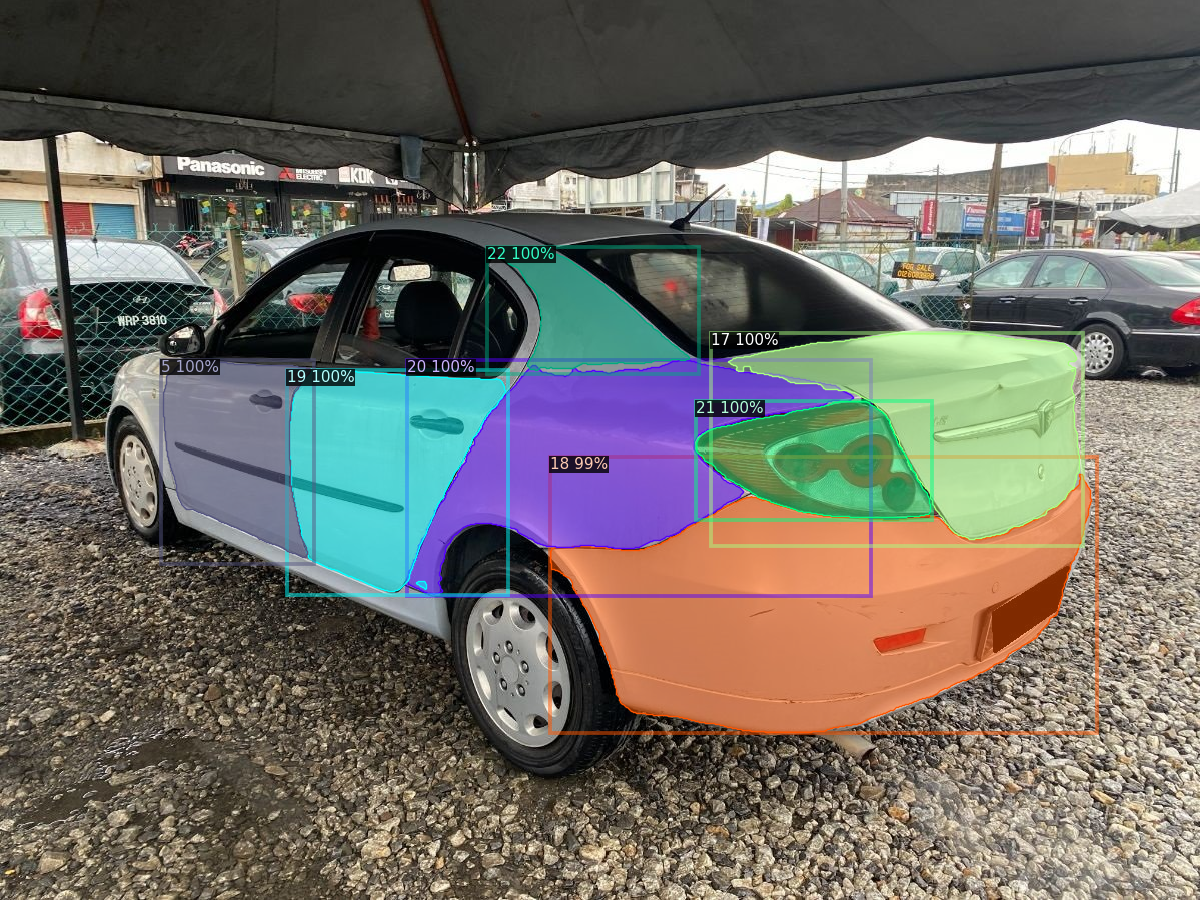

In [138]:
im = '/Users/maixueqiao/Downloads/Project/panel_detection/images/carro_T12r7uZAYYDHOEcg.jpg'
img = np.asarray(Image.open(im))
car_results, panel_instances = panel_detector.predict(img)
display(Image.fromarray(car_results['image'].get_image()))

In [86]:
class DamageDetector():
    def __init__(self, config, checkpoint, threshold=0.1, model_device='cpu'):
        self.model = None
        self.classes = None
        self.class_metadata = None
        self.config = config
        self.checkpoint = checkpoint
        self.threshold = threshold
        self.model_device = model_device
        self.initialise()

    def initialise(self):
        self.classes = {
            'dent': 0,
            'paint_deterioration': 1,
            'scratch': 2,
            'dirt': 3,
            'reflection': 4,
        }
        self.class_metadata = MetadataCatalog.get('_').set(
            thing_classes=list(self.classes.keys())
            )
        
        cfg = get_cfg()
        add_pointrend_config(cfg)
        cfg.merge_from_file(self.config)
        cfg.MODEL.WEIGHTS = self.checkpoint
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = self.threshold
        cfg.MODEL.DEVICE = self.model_device
        self.model = DefaultPredictor(cfg)
    
    def predict(self, img, filter_class=True):
        start_time = time.time()
        predictions = self.model(img)
        
        instances = predictions["instances"].to("cpu")
        
        if filter_class:
            # Filter and remove dirt and reflection classses
            instances = instances[instances.pred_classes != self.classes["dirt"]]
            instances = instances[instances.pred_classes != self.classes["reflection"]]

        '''
        # Filter center points to make sure that it is in the segmentation mask
        for row in instances.pred_boxes.get_centers().numpy().astype('int'):
            print(mask[row[1], row[0]])
        '''
        # TODO: Figure out how to filter using numpy arrays

        v = Visualizer(
            img_rgb=img,
            metadata=self.class_metadata,
            instance_mode=ColorMode.SEGMENTATION
            )

        out = v.draw_instance_predictions(
            instances
            )
            
        result = {
            'image' : out,
            'scratch_count' : len(instances[instances.pred_classes == self.classes["scratch"]]),
            'paint_deterioration_count' : len(instances[instances.pred_classes == self.classes["paint_deterioration"]]),
            'dent_count' : len(instances[instances.pred_classes == self.classes["dent"]]),
        }

        return result, instances


In [91]:
# Car Detection class
class CarDetector():
    def __init__(self, config, checkpoint, threshold=0.6, model_device='cpu'):
        self.model = None
        self.config = config
        self.checkpoint = checkpoint
        self.threshold = threshold
        self.model_device = model_device
        self.initialise()

    def initialise(self):
        cfg = get_cfg()
        add_pointrend_config(cfg)
        cfg.merge_from_file(self.config)
        cfg.MODEL.WEIGHTS = self.checkpoint
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = self.threshold
        cfg.MODEL.DEVICE = self.model_device
        self.model = DefaultPredictor(cfg)
    
    def predict(self, img):
        start_time = time.time()
        predictions = self.model(img)

        # Get detection boxes
        boxes = predictions['instances'].pred_boxes
        masks = predictions['instances'].pred_masks

        # If no boxes are detected, return original image and None for mask
        if len(boxes) == 0:
            return Image.fromarray(img), None
        else:
            # Crop Image
            box = list(boxes)[0].detach().cpu().numpy()
            cropped = self.crop_object(img, box)
            
            # Crop segmentation mask
            mask = list(masks)[0].detach().cpu().numpy()
            cropped_mask = self.crop_object(mask, box)
            
            return cropped, cropped_mask

    def crop_object(self, image, box):
        image = Image.fromarray(image)
        crop_img = image.crop(
            (int(box[0]), int(box[1]), int(box[2]), int(box[3]))
            )
        return crop_img
    

In [92]:
# Create CarDetector object
car_detector = CarDetector(
    config='damage_detection_data_batch_1/pointrend_rcnn_R_50_FPN_3x_coco.yaml',
    checkpoint='car_detection_model/car_detector_1.pth'
    )

car_detector

INFO:fvcore.common.checkpoint:[Checkpointer] Loading from car_detection_model/car_detector_1.pth ...
INFO:detectron2.checkpoint.c2_model_loading:Following weights matched with model:
| Names in Model                                            | Names in Checkpoint                                                                                  | Shapes                                          |
|:----------------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*                         | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*                         | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (

In [93]:
# Create DamageDetector object
damage_detector = DamageDetector(
    config='damage_detection_data_batch_1/pointrend_rcnn_R_50_FPN_3x_coco.yaml',
    checkpoint='damage_model/damage_detector_1.pth',
    threshold=0.3
    )

damage_detector

INFO:fvcore.common.checkpoint:[Checkpointer] Loading from damage_model/damage_detector_1.pth ...
INFO:detectron2.checkpoint.c2_model_loading:Following weights matched with model:
| Names in Model                                            | Names in Checkpoint                                                                                  | Shapes                                          |
|:----------------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*                         | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*                         | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,)

### Visualise Damage

/Users/maixueqiao/opt/miniconda3/envs/my_env/lib/python3.10/site-packages/detectron2/projects/point_rend/point_features.py:142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  point_coords[:, :, 1] = h_step / 2.0 + (point_indices // W).to(torch.float) * h_step


Input:


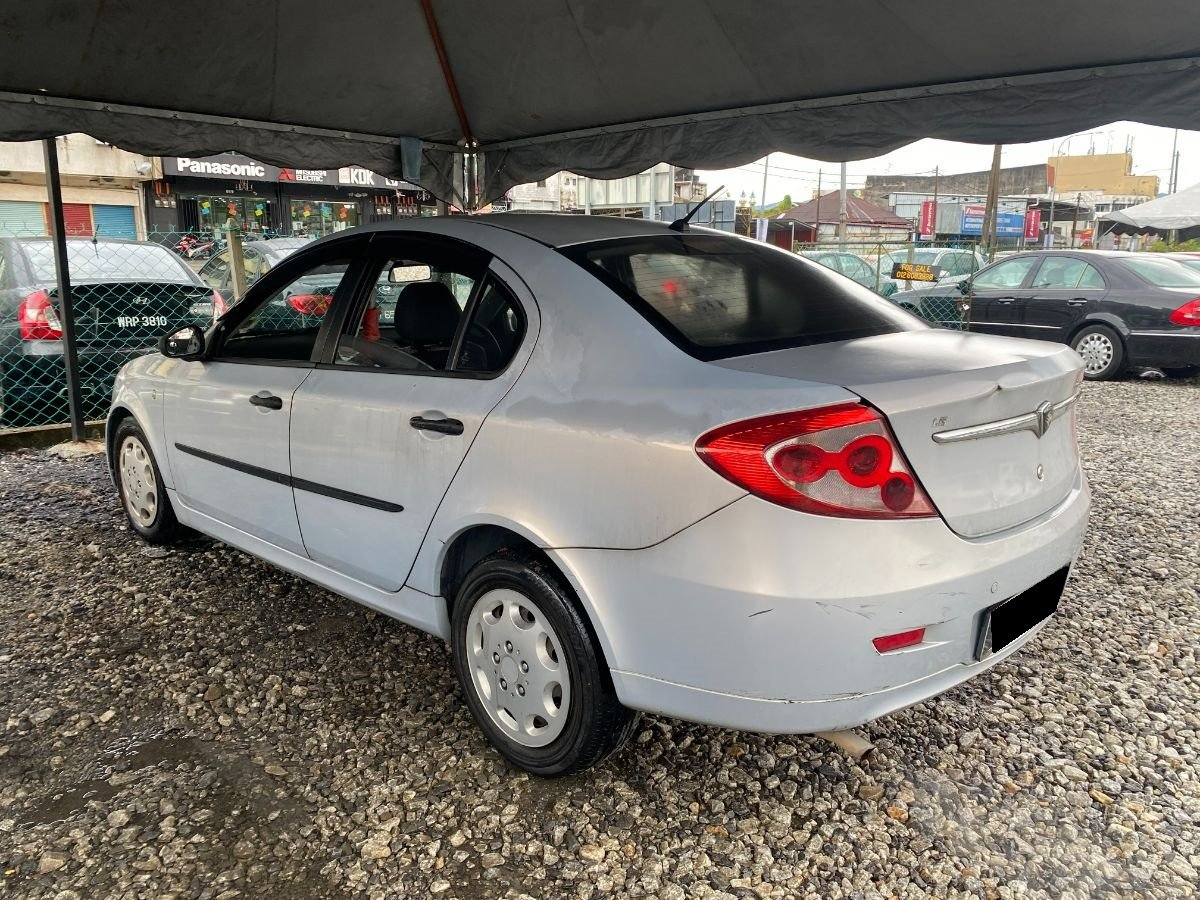

Result:


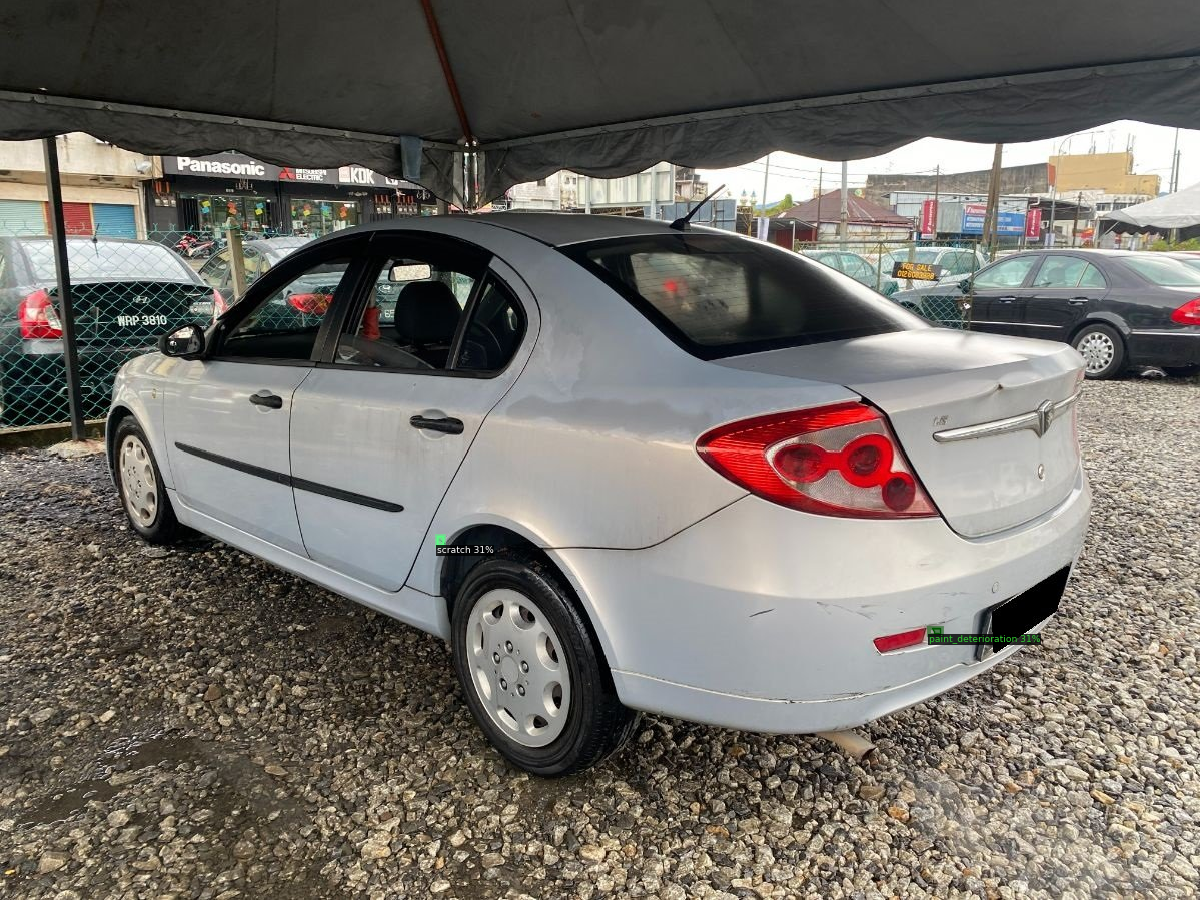

In [139]:
from detectron2.utils.visualizer import ColorMode
from IPython.display import display

# images = os.listdir('images')

im = '/Users/maixueqiao/Downloads/Project/panel_detection/images/' + im
input_img = np.array(Image.open('/Users/maixueqiao/Downloads/Project/panel_detection/images/carro_T12r7uZAYYDHOEcg.jpg').convert('RGB'))

# Car detection
cropped, cropped_mask = car_detector.predict(input_img)

# Damage Detection
results, damage_instances = damage_detector.predict(np.array(cropped), filter_class=False)

print('Input:')
display(Image.fromarray(np.array(cropped)))

print('Result:')
display(Image.fromarray(results['image'].get_image()))

In [95]:
panel_classes = {
    'car_license_plate': 0,
    'front_bonnet': 1,
    'front_bumper': 2,
    'front_left_bonnet': 3,
    'front_left_bumper': 4,
    'front_left_door': 5,
    'front_left_fender': 6,
    'front_left_headlight': 7,
    'front_left_side_mirror': 8,
    'front_right_bonnet': 9,
    'front_right_bumper': 10,
    'front_right_door': 11,
    'front_right_fender': 12,
    'front_right_headlight': 13,
    'front_right_side_mirror': 14,
    'rear_bonnet': 15,
    'rear_bumper': 16,
    'rear_left_bonnet': 17,
    'rear_left_bumper': 18,
    'rear_left_door': 19,
    'rear_left_fender': 20,
    'rear_left_headlight': 21,
    'rear_left_side_panel': 22,
    'rear_right_bonnet': 23,
    'rear_right_bumper': 24,
    'rear_right_door': 25,
    'rear_right_fender': 26,
    'rear_right_headlight': 27,
    'rear_right_side_panel': 28}

damage_d = {
            0: 'dent',
            1: 'paint_deterioration',
            2: 'scratch',
            3: 'dirt',
            4: 'reflection'
        }


In [171]:
from shapely import geometry

def create_panel_dic(panel_instances):
    panel_dic = {}

    for i in range(len(panel_instances)):
        inst_mask = panel_instances[i].pred_masks.numpy()
        pred_class = panel_instances[i].pred_classes
        panel_name = [k for k, v in panel_classes.items() if v == pred_class]
        r, w, h = inst_mask.shape    
        panel_mask = GenericMask(inst_mask.reshape(w,h), w, h)
        
        for x in range(len(panel_mask.polygons)):
            polygon = panel_mask.polygons[x].reshape(-1,2)
            if panel_name[0] not in panel_dic:
                panel_dic[panel_name[0]] = list()
            panel_dic[panel_name[0]].append(geometry.Polygon(polygon))

    return panel_dic

def create_damage_dic(damage_instances, damage_d):
    damage_dic = {}
    # list of damage centroids
    damage_centroids = damage_instances.pred_boxes.get_centers().cpu().numpy()

    damage_classes = damage_instances.pred_classes.to('cpu').numpy()
    for i, id in enumerate(damage_classes):
        class_name = [v for k,v in damage_d.items() if k==id]
        if class_name[0] not in damage_dic:
            damage_dic[class_name[0]] = list()
        damage_dic[class_name[0]].append(geometry.Point(damage_centroids[i]))

    return damage_dic

# check if point in polygon 

def locate_point(damage_dic, panel_dic):
    summary_d = {}
    for (damage_k,damage_v) in damage_dic.items():
        for damage in damage_v:
            found = False
            #print(damage)
            if not found:
                for (panel_key, panel_val) in panel_dic.items():
                    if panel_key not in summary_d:
                        summary_d[panel_key] = dict()
                    for polygon in panel_val:
                        if polygon.contains(damage):
                            if damage_k not in summary_d[panel_key]:
                                summary_d[panel_key][damage_k] = 1
                            else:
                               summary_d[panel_key][damage_k] += 1 
                            print('{} detected on {}!'.format(damage_k, panel_key))
                            found = True
                            break
                
                    if found:
                        break
            else:
                print('not located')
    return damage_k, panel_key, summary_d

damage_dic, panel_dic = create_damage_dic(damage_instances, damage_d), create_panel_dic(panel_instances)
damage_key, panel_key, damage_panel_d = locate_point(damage_dic, panel_dic)
damage_panel_d

paint_deterioration detected on rear_left_bumper!
scratch detected on rear_left_fender!


{'front_left_door': {},
 'rear_left_door': {},
 'rear_left_side_panel': {},
 'rear_left_bonnet': {},
 'rear_left_headlight': {},
 'rear_left_fender': {'scratch': 1},
 'rear_left_bumper': {'paint_deterioration': 1}}